In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from transformers import get_linear_schedule_with_warmup

warnings.filterwarnings("ignore")

In [2]:
import os
os.chdir('/Users/yzzz/Desktop/9417Group/data')

In [3]:
class args:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # to save model
    save_weights = True
    save_path='./'
    # k-fold
    k = 5
    folds = [0, 1, 2, 3, 4]
    #train
    batch_size = 128
    epochs = 150
    lr = 1e-3


In [4]:
traindata = pd.read_csv('train.csv', encoding='utf-8')
testdata = pd.read_csv('test.csv', encoding='utf-8')
datas = traindata[traindata['breath_id'] < 5].reset_index(drop=True)

In [5]:
def plot_fn(id, datas):
    '''
    Plot trends in pressure for each step
    :param id:
    :param datas:
    :return:
    '''
    sample = datas[datas['breath_id'] == id]
    r, c = sample[['R', 'C']].values[0]
    plt.figure(figsize=(12, 4))
    for i in ['u_in', 'u_out', 'pressure']:
        plt.plot(sample['time_step'], sample[i], label=i)
    plt.legend()
    plt.title(f'Sample {id} - R={r}, C={c}')

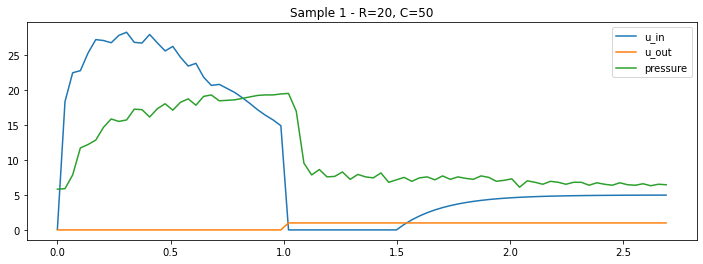

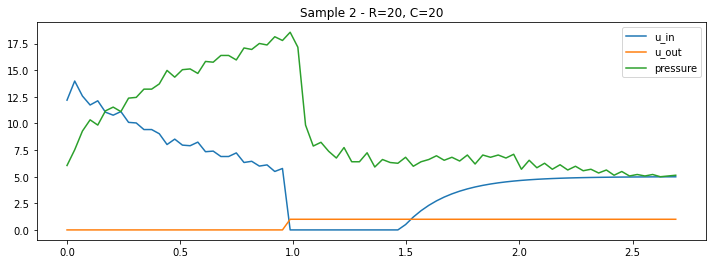

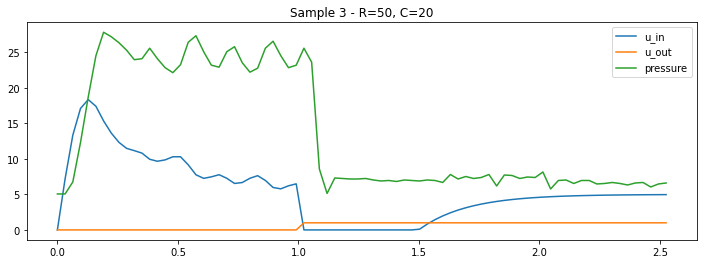

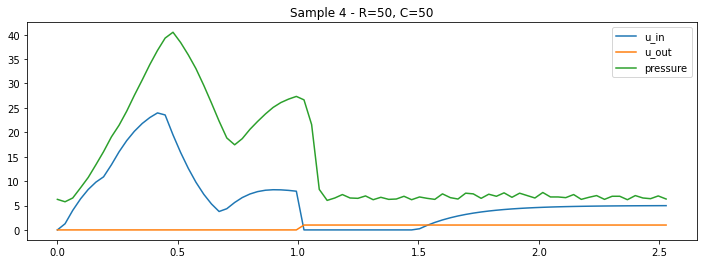

In [6]:
for i in datas['breath_id'].unique():
    plot_fn(i, traindata)

In [7]:
def minmaxscale(trainset, testset):
    '''
    Normalize trainset and testset using the min-max scaler, which can be substituded by robust scaler.
    :param trainset:
    :param testset:
    :return:
    '''
    train_tmp = trainset.drop(labels=['id', 'breath_id', 'pressure'], axis=1)
    test_tmp = testset.drop(labels=['id', 'breath_id'], axis=1)

    scaler = MinMaxScaler()
    scaler = scaler.fit(train_tmp)
    scaled_train = pd.DataFrame(scaler.transform(train_tmp))
    scaled_test = pd.DataFrame(scaler.transform(test_tmp))
    # maintain the columns
    scaled_train.columns = train_tmp.columns
    scaled_test.columns = test_tmp.columns
    for i in ['id', 'breath_id']:
        scaled_train[i] = trainset[i]
        scaled_test[i] = testset[i]
    scaled_train['pressure'] = trainset['pressure']
    # maintain the col order
    scaled_train = scaled_train[list(traindata.columns)]
    scaled_test = scaled_test[list(testdata.columns)]
    return scaled_train, scaled_test


In [8]:
traindata, testdata = minmaxscale(traindata, testdata)

In [9]:
class mydataset(Dataset):
    def __init__(self, df):
        # in case when test, there is no pressure column
        if "pressure" not in df.columns:
            df['pressure'] = -1
        # groupby breathid and reset index
        self.datas = df.groupby('breath_id').agg(list).reset_index()
        self.preprocess()

    def __len__(self):
        return self.datas.shape[0]

    def preprocess(self):
        # series to list to array
        self.pressures = np.array(self.datas['pressure'].values.tolist())#n*80
        self.R = np.array(self.datas['R'].values.tolist())
        self.C = np.array(self.datas['C'].values.tolist())
        self.u_in = np.array(self.datas['u_in'].values.tolist())
        self.u_outs = np.array(self.datas['u_out'].values.tolist())
        #concat the inputs
        self.data = np.concatenate([
            self.R[:, None],
            self.C[:, None],
            self.u_in[:, None],
            np.cumsum(self.u_in, 1)[:, None],
            self.u_outs[:, None]
        ], axis=1).transpose(0, 2, 1)#n*80*5

    def __getitem__(self, idx):
        item = {
            "data": torch.tensor(self.data[idx], dtype=torch.float),
            "u_out": torch.tensor(self.u_outs[idx], dtype=torch.float),
            "pressure": torch.tensor(self.pressures[idx], dtype=torch.float),
        }
        return item


In [10]:
trainset = mydataset(traindata)
print('input shape: %s, u_out: %s, p: %s' % (
trainset[0]['data'].shape, trainset[0]['u_out'].shape, trainset[0]['pressure'].shape))

input shape: torch.Size([80, 5]), u_out: torch.Size([80]), p: torch.Size([80])


In [11]:
class model_lstm(nn.Module):
    def __init__(self, in_dim=5, lstm_dim=512, fc_dim=512, out_dim=512, num_classes=1):
        super().__init__()
        self.in_head = nn.Sequential(
            nn.Linear(in_dim, fc_dim),
            nn.ReLU(),
            nn.Linear(fc_dim, fc_dim),
            nn.ReLU(),
        )
        self.lstm = nn.LSTM(fc_dim, lstm_dim,num_layers=1, batch_first=True, bidirectional=True)
        self.out_head = nn.Sequential(
            nn.Linear(lstm_dim * 2, out_dim),
            nn.ReLU(),
            nn.Linear(out_dim, num_classes),
        )

    def forward(self, x):
        x = self.in_head(x)
        x, _ = self.lstm(x)
        x = self.out_head(x)
        return x

In [12]:
class mae_loss(nn.Module):
    def __call__(self, y_pred, y_true, u_out):
        weights = 1 - u_out
        mae = weights * (y_true - y_pred).abs()
        return mae.sum(-1) / weights.sum(-1)

def mae_score(datas, y_pred):
    y_true = np.array(datas['pressure'].values.tolist())
    weights = 1 - np.array(datas['u_out'].values.tolist())
    mae = weights * np.abs(y_true - y_pred)
    return mae.sum() / weights.sum()

In [13]:
def trainloop(model, trainset, testset, optimizer="Adam", epochs=100, batch_size=128,
              warmup_prop=0.1, lr=1e-3, print_step=20, first_epoch_eval=0, device=args.device):
    '''
    fit the model
    :param model:
    :param trainset:
    :param testset:
    :param optimizer:
    :param epochs:
    :param batch_size:
    :param warmup_prop: param for scheduler
    :param lr:
    :param print_step: param for visualization
    :param first_epoch_eval:
    :param device:
    :return:
    '''
    optimizer = getattr(torch.optim, optimizer)(model.parameters(), lr=lr)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True, )
    val_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    criterion = mae_loss()
    # set the scheduler steps
    num_warmup_steps = int(warmup_prop * epochs * len(train_loader))
    num_training_steps = int(epochs * len(train_loader))
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)
    for epoch in range(epochs):
        model.train()
        model.zero_grad()
        avg_loss = 0
        for batch in train_loader:
            y_pred = model(batch['data'].to(device)).squeeze()
            loss = criterion(y_pred, batch['pressure'].to(device), batch['u_out'].to(device), ).mean()
            loss.backward()
            avg_loss += loss.item() / len(train_loader)
            optimizer.step()
            scheduler.step()
        model.eval()
        mae, avg_val_loss = 0, 0
        y_preds = []
        with torch.no_grad():
            for batch in val_loader:
                y_pred = model(batch['data'].to(device)).squeeze(-1)
                loss = criterion(y_pred.detach(), batch['pressure'].to(device),
                                 batch['u_out'].to(device), ).mean()
                avg_val_loss += loss.item() / len(val_loader)
                y_preds.append(y_pred.detach().cpu().numpy())
        y_preds = np.concatenate(y_preds, 0)
        mae = mae_score(testset.datas, y_preds)
        if (epoch + 1) % print_step == 0:
            lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch + 1:02d}/{epochs:02d} \t lr={lr:.1e}\t"
                  f"loss={avg_loss:.3f}",
                  end="\t", )
            if (epoch + 1 >= first_epoch_eval) or (epoch + 1 == epochs):
                print(f"val_loss={avg_val_loss:.3f}\tmae={mae:.3f}")
            else:
                print()
    return y_preds


In [14]:
def predict(model, dataset, batch_size=256, device=args.device):
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    preds = []
    with torch.no_grad():
        for batch in loader:
            pred = model(batch['data'].to(device)).squeeze(-1)
            preds.append(pred.detach().cpu().numpy())
    preds = np.concatenate(preds, 0)
    return preds

In [15]:
def train(args, traindata, valdata, testdata, fold):
    model = model_lstm().to(args.device)
    model.zero_grad()
    train_dataset = mydataset(traindata)
    val_dataset = mydataset(valdata)
    test_dataset = mydataset(testdata)
    print(f"{len(train_dataset)} training breathes")
    print(f"{len(val_dataset)} validation breathes")
    pred_val = trainloop(
        model,
        train_dataset,
        val_dataset,
        epochs=args.epochs,
        batch_size=args.batch_size,
        lr=args.lr,
        device=args.device,
)
    pred_test = predict(
        model,
        test_dataset,
        device=args.device
    )
    if args.save_weights:
        torch.save(model.state_dict(), f'{args.save_path}/model_{fold}.pth')
    return pred_val, pred_test

In [16]:
def kfold(args, datas, testdata):
    '''
    cross validate model
    :param args:
    :param datas:
    :param testdata:
    :return:
    '''
    # init pred
    pred_oof = np.zeros(len(datas))
    preds_test = []
    groups = GroupKFold(n_splits=args.k)
    groupdata = list(groups.split(X=datas, y=datas, groups=datas["breath_id"]))
    for i, (train_idx, val_idx) in enumerate(groupdata):
        if i in args.folds:
            print(f"\n-------------   Fold {i + 1} / {args.k}  -------------\n")
            #split trainset and valset
            df_train = datas.iloc[train_idx].copy().reset_index(drop=True)
            df_val = datas.iloc[val_idx].copy().reset_index(drop=True)
            pred_val, pred_test = train(args, df_train, df_val, testdata, i)
            pred_oof[val_idx] = pred_val.flatten()
            preds_test.append(pred_test.flatten())
    print(f'\n -> CV MAE : {mae_score(datas, pred_oof) :.3f}')
    return pred_oof, np.mean(preds_test, 0)

In [17]:
pred_oof, pred_test = kfold(args, traindata, testdata)


-------------   Fold 1 / 5  -------------

60360 training breathes
15090 validation breathes
Epoch 20/150 	 lr=9.6e-04	loss=6.184	val_loss=4.453	mae=4.473
Epoch 40/150 	 lr=8.1e-04	loss=5.140	val_loss=6.095	mae=6.118
Epoch 60/150 	 lr=6.7e-04	loss=4.416	val_loss=5.203	mae=5.221
Epoch 80/150 	 lr=5.2e-04	loss=4.009	val_loss=4.210	mae=4.225
Epoch 100/150 	 lr=3.7e-04	loss=3.377	val_loss=3.658	mae=3.673
Epoch 120/150 	 lr=2.2e-04	loss=2.891	val_loss=3.079	mae=3.096
Epoch 140/150 	 lr=7.4e-05	loss=2.523	val_loss=2.545	mae=2.563

-------------   Fold 2 / 5  -------------

60360 training breathes
15090 validation breathes
Epoch 20/150 	 lr=9.6e-04	loss=3.670	val_loss=4.598	mae=4.611
Epoch 40/150 	 lr=8.1e-04	loss=4.424	val_loss=4.308	mae=4.328
Epoch 60/150 	 lr=6.7e-04	loss=4.583	val_loss=5.407	mae=5.424
Epoch 80/150 	 lr=5.2e-04	loss=4.066	val_loss=4.445	mae=4.460
Epoch 100/150 	 lr=3.7e-04	loss=3.412	val_loss=3.610	mae=3.624
Epoch 120/150 	 lr=2.2e-04	loss=2.943	val_loss=3.174	mae=3.191
E

In [18]:
def plot_prediction(sample_id, datas):
    sample = datas[datas['breath_id'] == sample_id]
    plt.figure(figsize=(12, 4))
    for i in ['pred', 'pressure', 'u_out']:
        plt.plot(sample['time_step'], sample[i], label=i)
    metric = mae_score(sample, sample['pred'])
    plt.legend()
    plt.title(f'Sample {sample_id} - MAE={metric:.3f}')

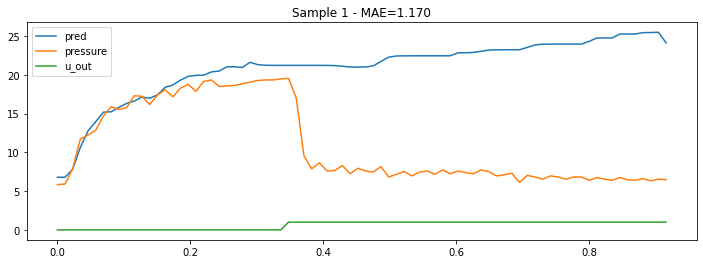

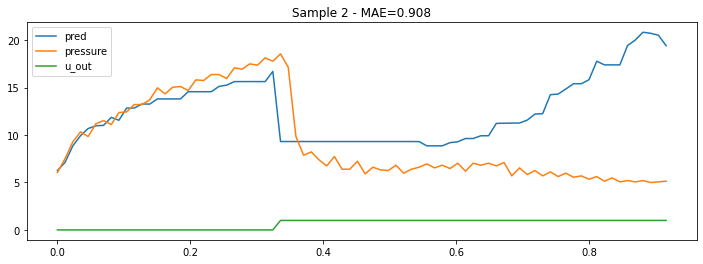

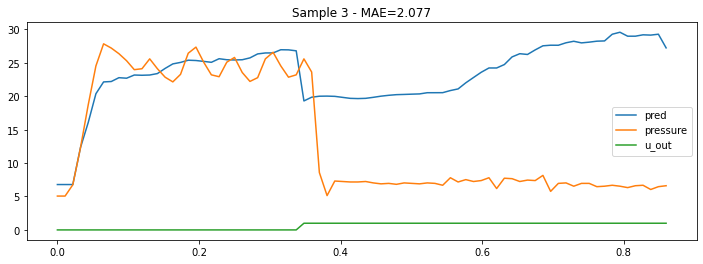

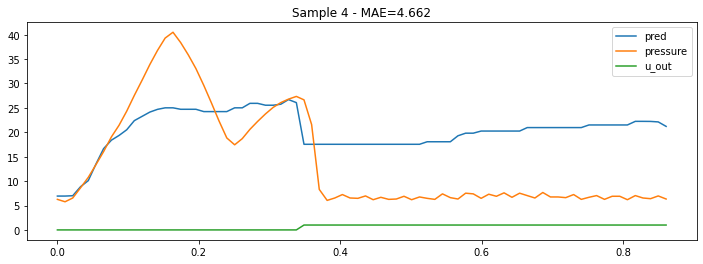

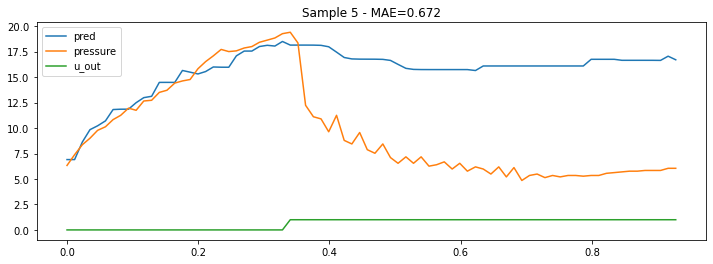

In [19]:
traindata["pred"] = pred_oof
for i in traindata['breath_id'].unique()[:5]:
    plot_prediction(i, traindata)

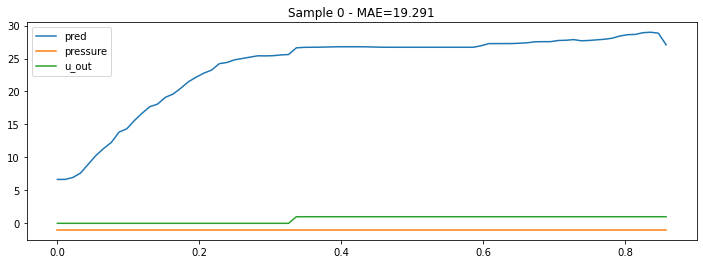

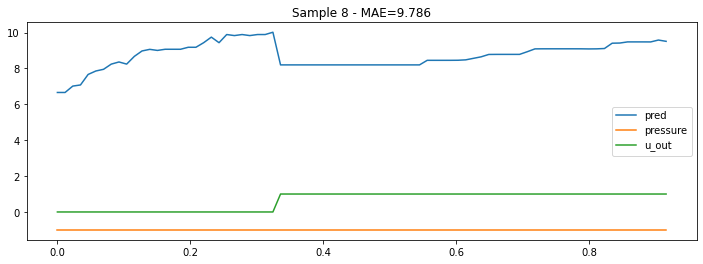

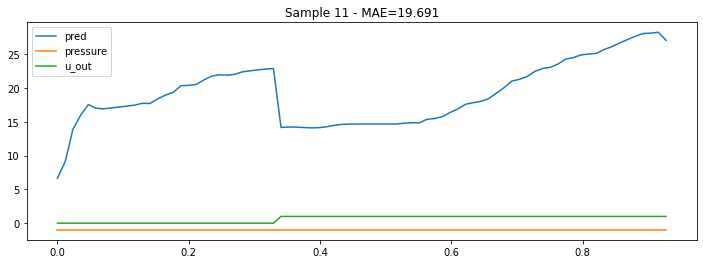

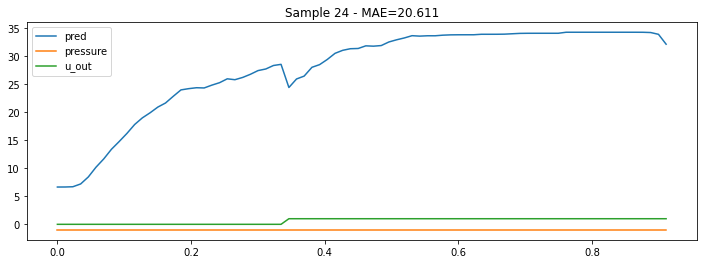

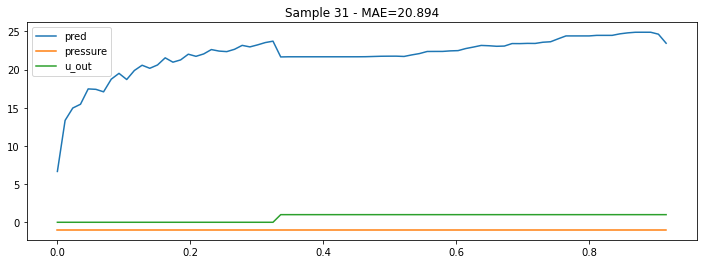

In [20]:
testdata['pred'] = pred_test
for i in testdata['breath_id'].unique()[:5]:
    plot_prediction(i, testdata)